# PQC TLS Benchmark

This notebook benchmarks Classic TLS (ECDHE) vs Post-Quantum Cryptography (Kyber768)

## Imports

In [ ]:
import sys
sys.path.append('..')

import time
import threading
import statistics
from src.tls_server import run_server
from src.tls_client import run_client_handshake
from src.pqc_kyber import measure_kyber_kem

## TLS Benchmark Function

In [7]:
def benchmark_tls(iterations=100):
    latencies = []
    
    # Start server in a separate thread
    server_thread = threading.Thread(target=run_server, daemon=True)
    server_thread.start()
    
    # Give server a moment to start
    time.sleep(1)
    
    for _ in range(iterations):
        lat = run_client_handshake()
        if lat is not None:
            latencies.append(lat)
        time.sleep(0.01) # Small delay to avoid overwhelming
        
    return latencies

## Kyber Benchmark Function

In [8]:
def benchmark_kyber(iterations=100):
    latencies = []
    pk_size = 0
    ct_size = 0
    
    for _ in range(iterations):
        res = measure_kyber_kem("Kyber768")
        if res:
            latencies.append(res["latency_ms"])
            pk_size = res["pk_size"]
            ct_size = res["ct_size"]
            
    return latencies, pk_size, ct_size

## Configuration

In [9]:
ITERATIONS = 100
print(f"Running benchmarks with {ITERATIONS} iterations...")

Running benchmarks with 100 iterations...


## Run Classic TLS Benchmark

In [10]:
print("Benchmarking Classic TLS (ECDHE)...")
tls_latencies = benchmark_tls(ITERATIONS)
if not tls_latencies:
    print("TLS Benchmark failed!")
else:
    tls_mean = statistics.mean(tls_latencies)
    tls_stdev = statistics.stdev(tls_latencies)
    print(f"Completed: {len(tls_latencies)} samples")

Benchmarking Classic TLS (ECDHE)...
Completed: 100 samples


## Run PQC Kyber Benchmark

In [11]:
print("Benchmarking PQC (Kyber768)...")
kyber_latencies, kyber_pk_size, kyber_ct_size = benchmark_kyber(ITERATIONS)

kyber_mean = statistics.mean(kyber_latencies)
kyber_stdev = statistics.stdev(kyber_latencies)
print(f"Completed: {len(kyber_latencies)} samples")

Benchmarking PQC (Kyber768)...
Completed: 100 samples


## Results Report

In [13]:
import matplotlib.pyplot as plt
import numpy as np

/tmp/ipykernel_6366/1727417671.py:56: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax3.boxplot(box_data, labels=categories, patch_artist=True,


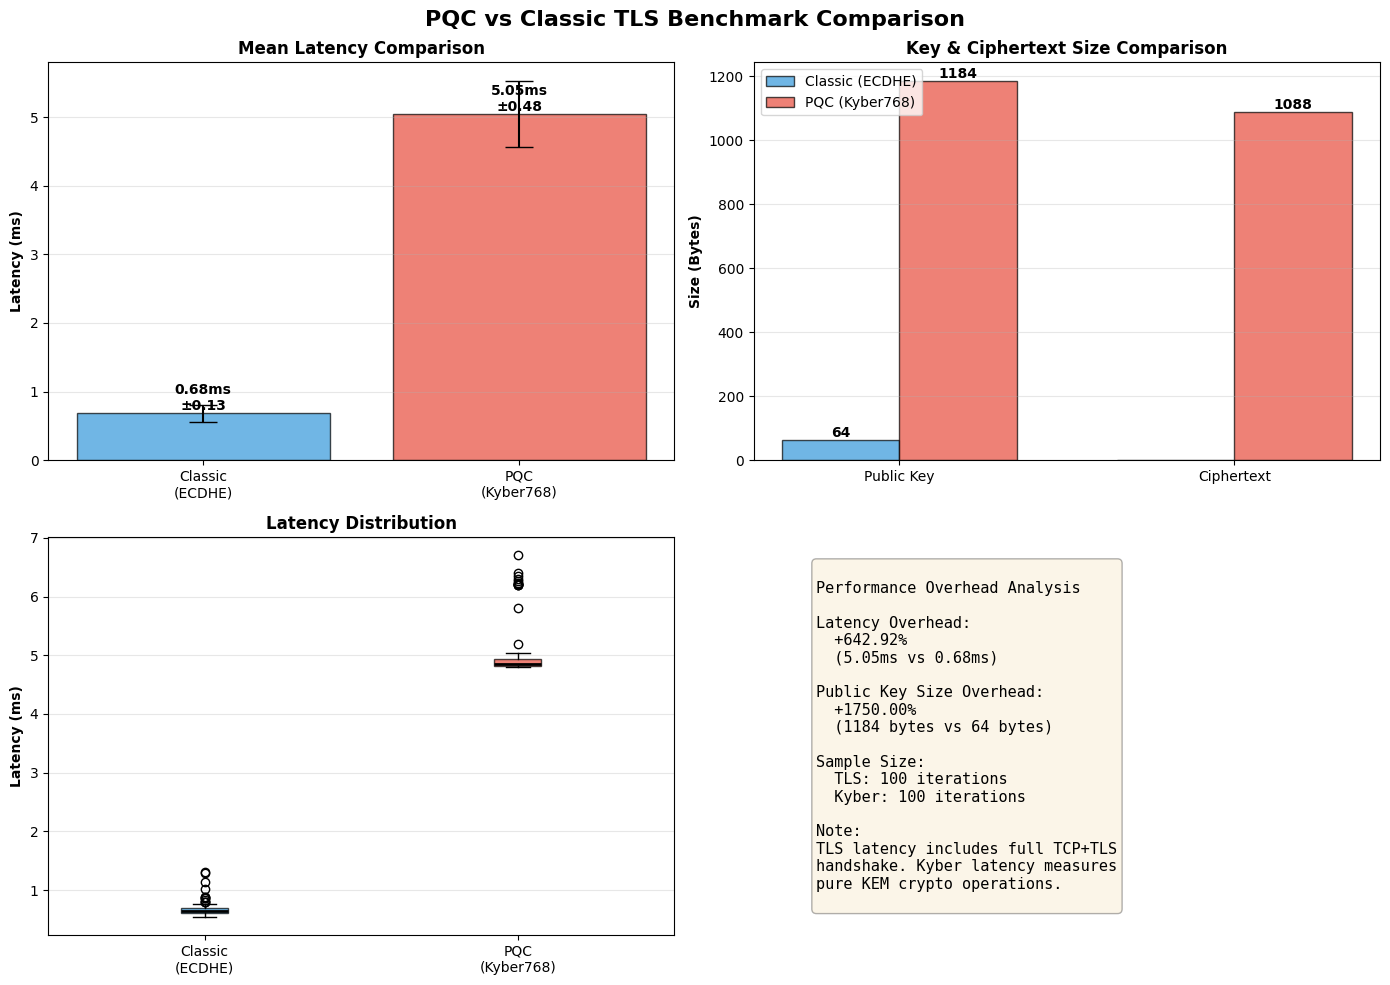

In [14]:
# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('PQC vs Classic TLS Benchmark Comparison', fontsize=16, fontweight='bold')

# 1. Latency Comparison (Bar Chart)
ax1 = axes[0, 0]
categories = ['Classic\n(ECDHE)', 'PQC\n(Kyber768)']
means = [tls_mean, kyber_mean]
stdevs = [tls_stdev, kyber_stdev]
colors = ['#3498db', '#e74c3c']

bars = ax1.bar(categories, means, yerr=stdevs, capsize=10, color=colors, alpha=0.7, edgecolor='black')
ax1.set_ylabel('Latency (ms)', fontweight='bold')
ax1.set_title('Mean Latency Comparison', fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, mean, std in zip(bars, means, stdevs):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{mean:.2f}ms\n±{std:.2f}',
             ha='center', va='bottom', fontweight='bold')

# 2. Key Size Comparison (Bar Chart)
ax2 = axes[0, 1]
ecdhe_pk_size = 64
ecdhe_ct_size = 0

x = np.arange(2)
width = 0.35

bars1 = ax2.bar(x - width/2, [ecdhe_pk_size, ecdhe_ct_size], width,
                label='Classic (ECDHE)', color='#3498db', alpha=0.7, edgecolor='black')
bars2 = ax2.bar(x + width/2, [kyber_pk_size, kyber_ct_size], width,
                label='PQC (Kyber768)', color='#e74c3c', alpha=0.7, edgecolor='black')

ax2.set_ylabel('Size (Bytes)', fontweight='bold')
ax2.set_title('Key & Ciphertext Size Comparison', fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(['Public Key', 'Ciphertext'])
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                     f'{int(height)}',
                     ha='center', va='bottom', fontweight='bold')

# 3. Latency Distribution (Box Plot)
ax3 = axes[1, 0]
box_data = [tls_latencies, kyber_latencies]
bp = ax3.boxplot(box_data, labels=categories, patch_artist=True,
                 boxprops=dict(alpha=0.7),
                 medianprops=dict(color='black', linewidth=2))

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

ax3.set_ylabel('Latency (ms)', fontweight='bold')
ax3.set_title('Latency Distribution', fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# 4. Overhead Comparison (Pie/Text Summary)
ax4 = axes[1, 1]
ax4.axis('off')

latency_overhead = ((kyber_mean - tls_mean) / tls_mean) * 100
size_overhead = ((kyber_pk_size - ecdhe_pk_size) / ecdhe_pk_size) * 100

summary_text = f"""
Performance Overhead Analysis

Latency Overhead:
  {latency_overhead:+.2f}%
  ({kyber_mean:.2f}ms vs {tls_mean:.2f}ms)

Public Key Size Overhead:
  {size_overhead:+.2f}%
  ({kyber_pk_size} bytes vs {ecdhe_pk_size} bytes)

Sample Size:
  TLS: {len(tls_latencies)} iterations
  Kyber: {len(kyber_latencies)} iterations

Note:
TLS latency includes full TCP+TLS
handshake. Kyber latency measures
pure KEM crypto operations.
"""

ax4.text(0.1, 0.5, summary_text, fontsize=11, verticalalignment='center',
         fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.show()